In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from packaging import version
from tensorflow.keras import layers, models, backend as k
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error as MSE, confusion_matrix
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import tensorflow_datasets as tfds
import re
import string
import time

In [ ]:
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

TensorFlow version:  2.15.0


In [ ]:
!tfds build --register_checksums --datasets=ag_news_subset

Traceback (most recent call last):
  File "/usr/local/bin/tfds", line 5, in <module>
    from tensorflow_datasets.scripts.cli.main import launch_cli
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/main.py", line 37, in <module>
    from tensorflow_datasets.scripts.cli import convert_format
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/convert_format.py", line 32, in <module>
    from tensorflow_datasets.scripts.cli import convert_format_utils
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/convert_format_utils.py", line 169, in <module>
    pipeline: beam.Pipeline | None = None,
  File "/usr/local/lib/python3.10/dist-packages/etils/epy/lazy_imports_utils.py", line 90, in __getattr__
    return getattr(self._module, name)
  File "/usr/lib/python3.10/functools.py", line 981, in __get__
    val = self.func(instance)
  File "/usr/local/lib/python3.10/dist-packages/etils/epy/lazy_imports_utils.

In [ ]:
# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)
text_only_dataset_all=dataset_all.map(lambda x, y: x)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.MFOYV5_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.MFOYV5_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Check the dataframe
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [ ]:
# Check the categories
categories =dict(enumerate(info.features["label"].names))
print(f'Dictionary: ',categories)

Dictionary:  {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


In [ ]:
# Review Class Balance
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [ ]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [ ]:
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

In [ ]:
# Custom Stopwords Function
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*', '')

# Text Vectorization and Vocabulary Adaptation
def text_vectorization_and_adapt(text_dataset, max_tokens=None, standardize_fn=None, output_sequence_length=None):
    text_vectorization = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        standardize=standardize_fn,
        output_sequence_length=output_sequence_length
    )
    text_vectorization.adapt(text_dataset)
    return text_vectorization

In [ ]:
# Train and Evaluate Models with Different Vocabulary Sizes
def create_model(vocab_size, output_sequence_length):
    k.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)
    x = layers.LSTM(32, return_sequences=False)(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="SparseCategoricalCrossentropy",
                  metrics=["accuracy"])
    return model


In [ ]:
def train_and_evaluate_unidirectional_model(vocab_size, text_vectorization, output_sequence_length, model_name):
    print(f"Starting experiment: {model_name} with vocab size {vocab_size}")

    # Prepare the dataset
    def vectorize_text(text, label):
        text = text_vectorization(text)
        return text, label

    vectorized_dataset = dataset_all.map(vectorize_text)
    vectorized_dataset = vectorized_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    # Split the dataset
    dataset_size = len(list(vectorized_dataset))
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size

    train_dataset = vectorized_dataset.take(train_size).batch(32)
    val_dataset = vectorized_dataset.skip(train_size).take(val_size).batch(32)

    # Train the model
    model = create_model(vocab_size, output_sequence_length)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(f"{model_name}.h5", save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
    start_time = time.time()
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=callbacks)
    training_time = time.time() - start_time

    # Evaluate on validation dataset
    val_loss, val_accuracy = model.evaluate(val_dataset)

    # Load the best model and evaluate on validation dataset
    model = models.load_model(f"{model_name}.h5")
    test_loss, test_accuracy = model.evaluate(val_dataset)

    # Collect final train accuracy and loss
    train_acc = history.history['accuracy'][-1]
    train_loss = history.history['loss'][-1]

    return {
        'model_name': model_name,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'train_time': training_time,
        'val_acc': val_accuracy,
        'val_loss': val_loss,
        'test_acc': test_accuracy,
        'test_loss': test_loss,
        'history': history  # Ensure history is returned
    }


In [ ]:
# Experiment with unedited and edited vocabularies
experiments = [
    {"name": "unedited", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": None, "output_sequence_length": 100},
    {"name": "edited", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": custom_stopwords, "output_sequence_length": 100},
    {"name": "unedited_fixed_length", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": None, "output_sequence_length": 100},
    {"name": "edited_fixed_length", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": custom_stopwords, "output_sequence_length": 100}
]

In [ ]:
# Collecting results for unidirectional model
all_results_unidirectional = []
for experiment in experiments:
    for vocab_size in experiment["vocab_sizes"]:
        try:
            text_vectorization = text_vectorization_and_adapt(
                dataset_all.map(lambda text, label: text),
                max_tokens=vocab_size,
                standardize_fn=experiment["standardize_fn"],
                output_sequence_length=experiment["output_sequence_length"]
            )
            results = train_and_evaluate_unidirectional_model(vocab_size, text_vectorization, experiment["output_sequence_length"], experiment["name"])
            all_results_unidirectional.append(results)
        except ValueError as e:
            print(f"Error with vocab_size {vocab_size}: {e}")

Starting experiment: unedited with vocab size 5000
Epoch 1/200
3190/3190 [==============================] - 33s 9ms/step - loss: 1.3875 - accuracy: 0.2511 - val_loss: 1.3878 - val_accuracy: 0.2485
Epoch 2/200
  19/3190 [..............................] - ETA: 18s - loss: 1.3853 - accuracy: 0.2681

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3190/3190 [==============================] - 21s 6ms/step - loss: 1.3861 - accuracy: 0.2508 - val_loss: 1.3867 - val_accuracy: 0.2485
Epoch 3/200
3190/3190 [==============================] - 21s 7ms/step - loss: 1.3235 - accuracy: 0.3303 - val_loss: 1.1223 - val_accuracy: 0.4958
Epoch 4/200
3190/3190 [==============================] - 21s 6ms/step - loss: 1.1467 - accuracy: 0.4309 - val_loss: 1.1344 - val_accuracy: 0.4143
Epoch 5/200
3190/3190 [==============================] - 22s 7ms/step - loss: 1.1291 - accuracy: 0.4495 - val_loss: 1.0991 - val_accuracy: 0.4481
Epoch 6/200
798/798 [==============================] - 3s 3ms/step - loss: 1.0733 - accuracy: 0.4521
Starting experiment: unedited with vocab size 10000
Epoch 1/200
3190/3190 [==============================] - 32s 10ms/step - loss: 1.3876 - accuracy: 0.2497 - val_loss: 1.3879 - val_accuracy: 0.2485
Epoch 2/200
3190/3190 [==============================] - 21s 7ms/step - loss: 1.3865 - accuracy: 0.2505 - val_loss: 1.3872 - val

In [ ]:
# Adjust display settings for better alignment
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [ ]:
# Create a DataFrame to display the results
df_unidirectional = pd.DataFrame(all_results_unidirectional)

# Display the DataFrame
print(df_unidirectional)

               model_name  train_acc  train_loss  train_time   val_acc  val_loss  test_acc  test_loss                                            history
0                unedited   0.442525    1.104049  138.695572  0.452077  1.073334  0.452077   1.073334  <keras.src.callbacks.History object at 0x79345...
1                unedited   0.937441    0.222545  306.012837  0.890596  0.357842  0.895572   0.321881  <keras.src.callbacks.History object at 0x79337...
2                unedited   0.252380    1.386382  102.549499  0.248511  1.386750  0.248511   1.386750  <keras.src.callbacks.History object at 0x7933b...
3                  edited   0.250362    1.386564   97.632819  0.248511  1.386764  0.248511   1.386717  <keras.src.callbacks.History object at 0x79345...
4                  edited   0.250500    1.386552   98.854450  0.248511  1.386791  0.248511   1.386781  <keras.src.callbacks.History object at 0x79333...
5                  edited   0.251048    1.386602  101.708936  0.248511  1.386603  

Model: unedited, Vocab Size: unedited, History Data: {'loss': [1.3874974250793457, 1.386115550994873, 1.3235359191894531, 1.1466615200042725, 1.129076361656189, 1.104048728942871], 'accuracy': [0.25110697746276855, 0.2507934868335724, 0.330319344997406, 0.43085816502571106, 0.44953957200050354, 0.4425254762172699], 'val_loss': [1.387844204902649, 1.3867063522338867, 1.1222798824310303, 1.1343677043914795, 1.099082350730896, 1.0733336210250854], 'val_accuracy': [0.24851097166538239, 0.24851097166538239, 0.4958072006702423, 0.4142633080482483, 0.4481191337108612, 0.45207679271698]}
Model: unedited, Vocab Size: unedited, History Data: {'loss': [1.3875521421432495, 1.3865187168121338, 1.3859659433364868, 1.336401343345642, 1.2623246908187866, 1.247323751449585, 1.1696066856384277, 0.8359293937683105, 0.3993697166442871, 0.31818127632141113, 0.2815992832183838, 0.2569315433502197, 0.2381652444601059, 0.22254504263401031], 'accuracy': [0.24972569942474365, 0.25045064091682434, 0.254418104887

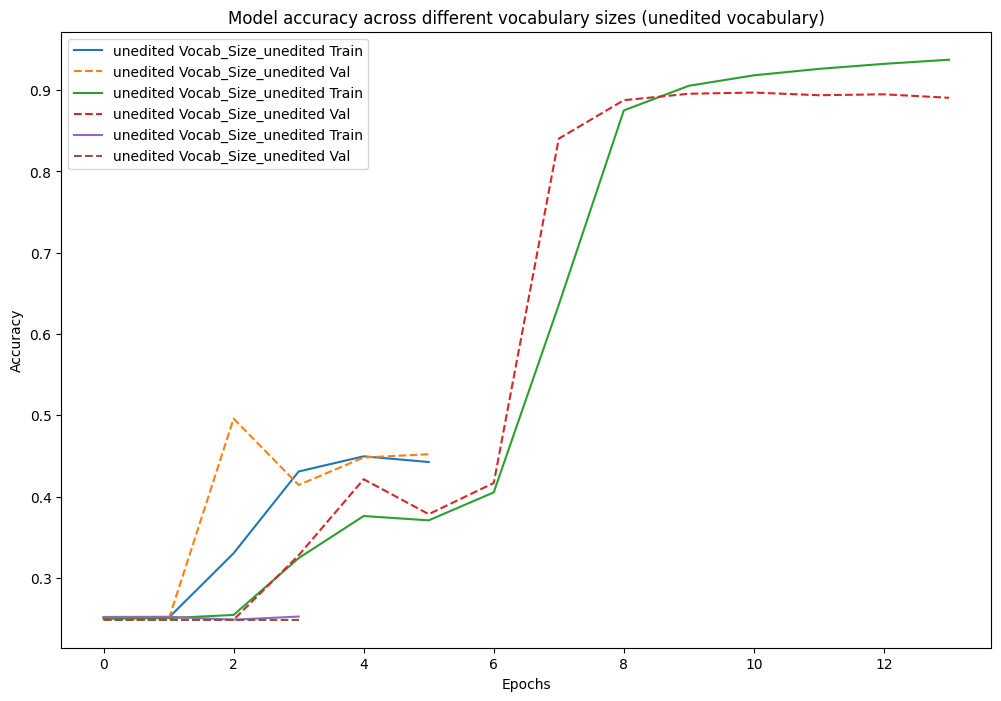

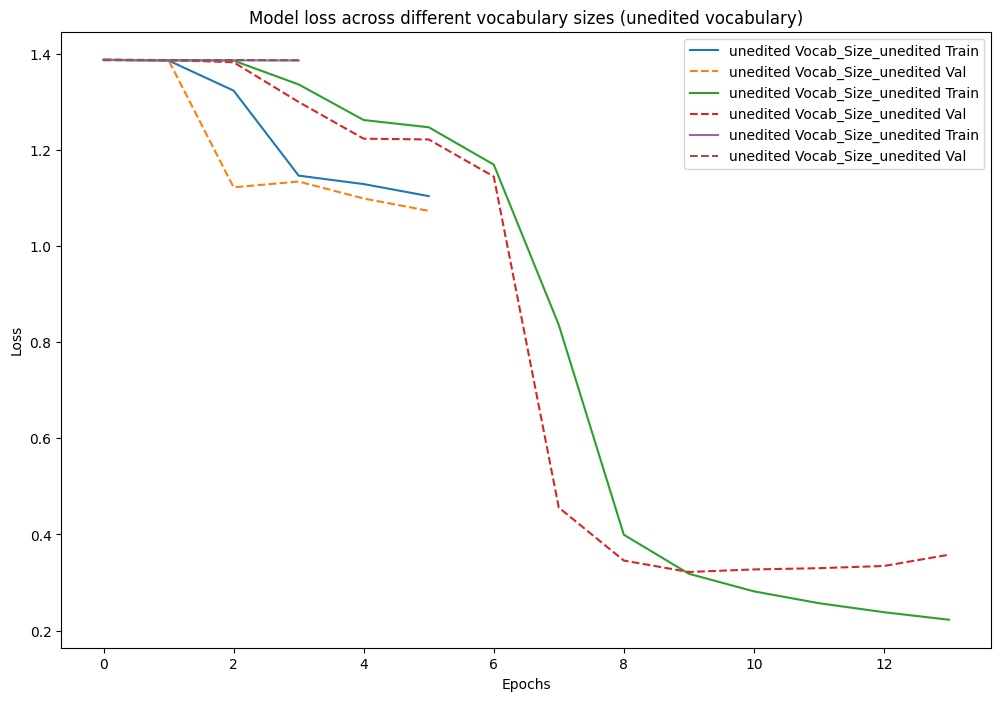

Model: edited, Vocab Size: edited, History Data: {'loss': [1.3876593112945557, 1.3868101835250854, 1.3866826295852661, 1.3865641355514526], 'accuracy': [0.25103840231895447, 0.25292906165122986, 0.2500391900539398, 0.25036245584487915], 'val_loss': [1.3868255615234375, 1.3868129253387451, 1.3867170810699463, 1.3867641687393188], 'val_accuracy': [0.24851097166538239, 0.24851097166538239, 0.24851097166538239, 0.24851097166538239]}
Model: edited, Vocab Size: edited, History Data: {'loss': [1.3874863386154175, 1.3868491649627686, 1.3866690397262573, 1.386551856994629], 'accuracy': [0.25156739354133606, 0.24877546727657318, 0.25103840231895447, 0.2504996061325073], 'val_loss': [1.3873751163482666, 1.3867813348770142, 1.386798620223999, 1.3867906332015991], 'val_accuracy': [0.24851097166538239, 0.24851097166538239, 0.24851097166538239, 0.24851097166538239]}
Model: edited, Vocab Size: edited, History Data: {'loss': [1.3875752687454224, 1.386864423751831, 1.386728048324585, 1.3866018056869507]

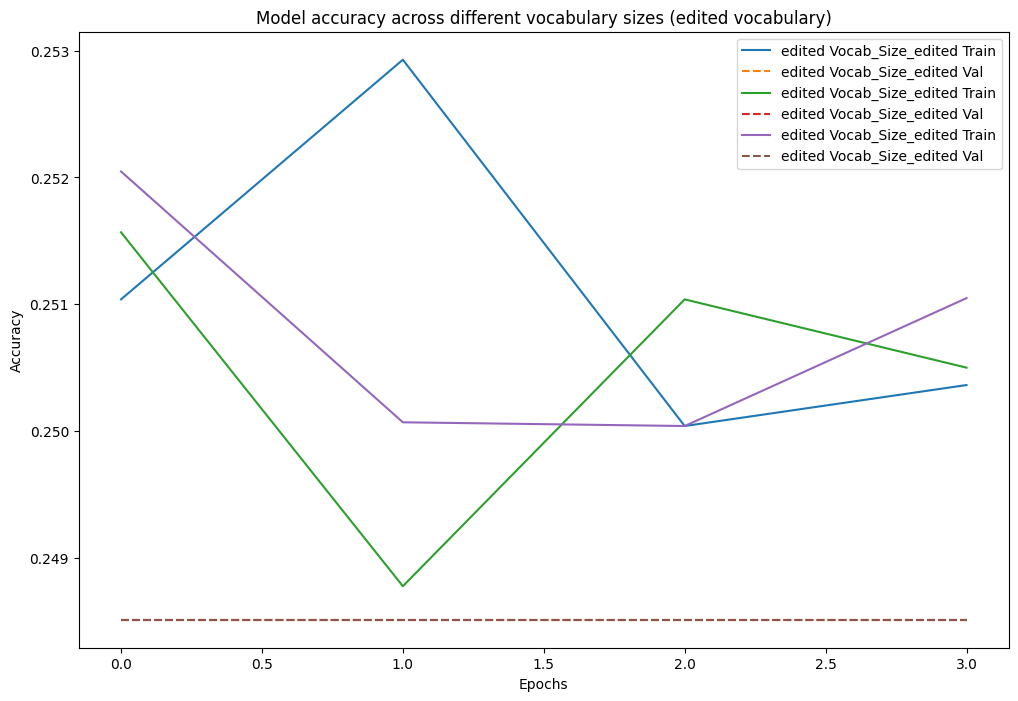

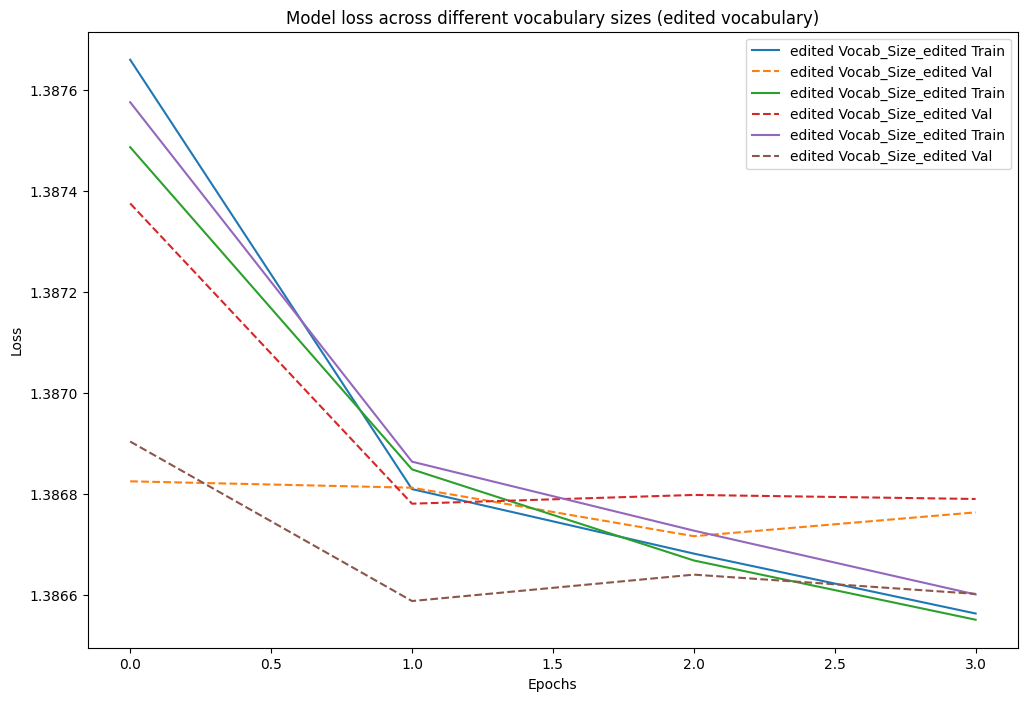

Model: unedited_fixed_length, Vocab Size: unedited_fixed_length, History Data: {'loss': [1.387427568435669, 1.3864233493804932, 1.312726378440857, 1.1370997428894043, 1.0537147521972656, 0.9473806619644165, 0.9310771226882935, 0.9041993618011475, 0.8314866423606873, 0.5979070067405701, 0.46098560094833374, 0.34935206174850464, 0.3112524151802063, 0.28957951068878174, 0.2738001048564911, 0.2605382800102234, 0.25003063678741455, 0.23555299639701843, 0.22442324459552765], 'accuracy': [0.2492554932832718, 0.25084248185157776, 0.3243730366230011, 0.43255290389060974, 0.46201997995376587, 0.48265087604522705, 0.4850117564201355, 0.4990301728248596, 0.5795650482177734, 0.6993436813354492, 0.8350215554237366, 0.8934561014175415, 0.9063381552696228, 0.9128232598304749, 0.9185149073600769, 0.9230309724807739, 0.9265869855880737, 0.9309561252593994, 0.9353448152542114], 'val_loss': [1.3868361711502075, 1.3853800296783447, 1.1667603254318237, 1.0985807180404663, 0.9417929649353027, 0.9361913800239

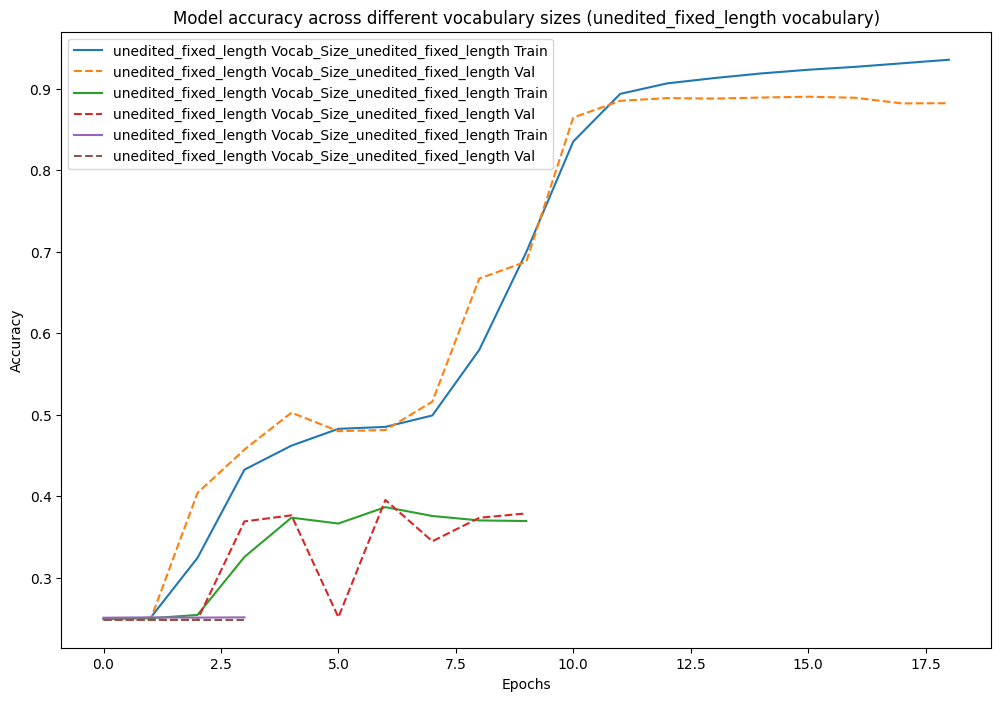

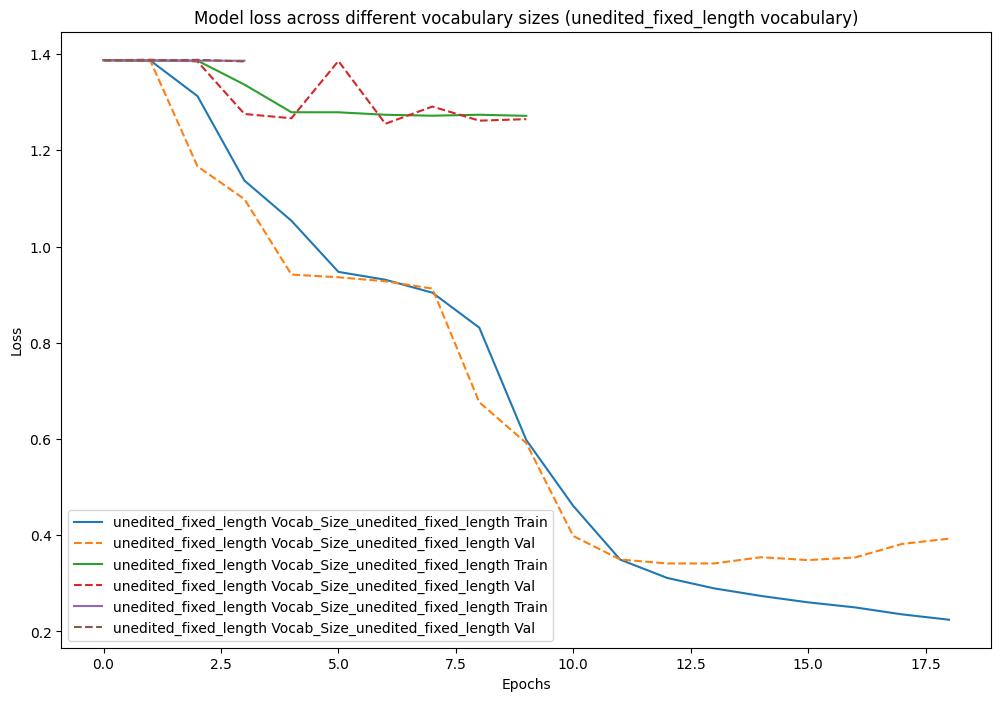

Model: edited_fixed_length, Vocab Size: edited_fixed_length, History Data: {'loss': [1.3877196311950684, 1.3868584632873535, 1.3867501020431519, 1.386586308479309], 'accuracy': [0.24908894300460815, 0.24849137663841248, 0.2502841055393219, 0.24986284971237183], 'val_loss': [1.386955976486206, 1.386665940284729, 1.3865679502487183, 1.386656641960144], 'val_accuracy': [0.24851097166538239, 0.24851097166538239, 0.24851097166538239, 0.24851097166538239]}
Model: edited_fixed_length, Vocab Size: edited_fixed_length, History Data: {'loss': [1.3874577283859253, 1.3868502378463745, 1.3866294622421265, 1.386613130569458], 'accuracy': [0.2511363625526428, 0.2519298493862152, 0.25202780961990356, 0.24880485236644745], 'val_loss': [1.3869221210479736, 1.3870632648468018, 1.3866335153579712, 1.3867595195770264], 'val_accuracy': [0.24851097166538239, 0.24851097166538239, 0.24851097166538239, 0.24851097166538239]}
Model: edited_fixed_length, Vocab Size: edited_fixed_length, History Data: {'loss': [1.3

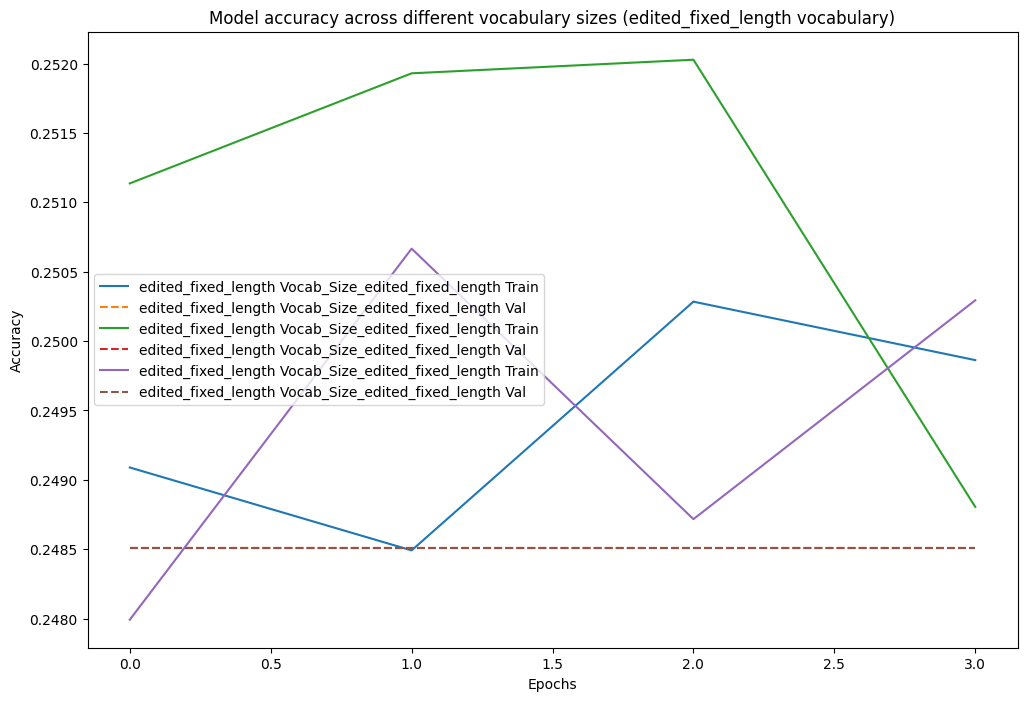

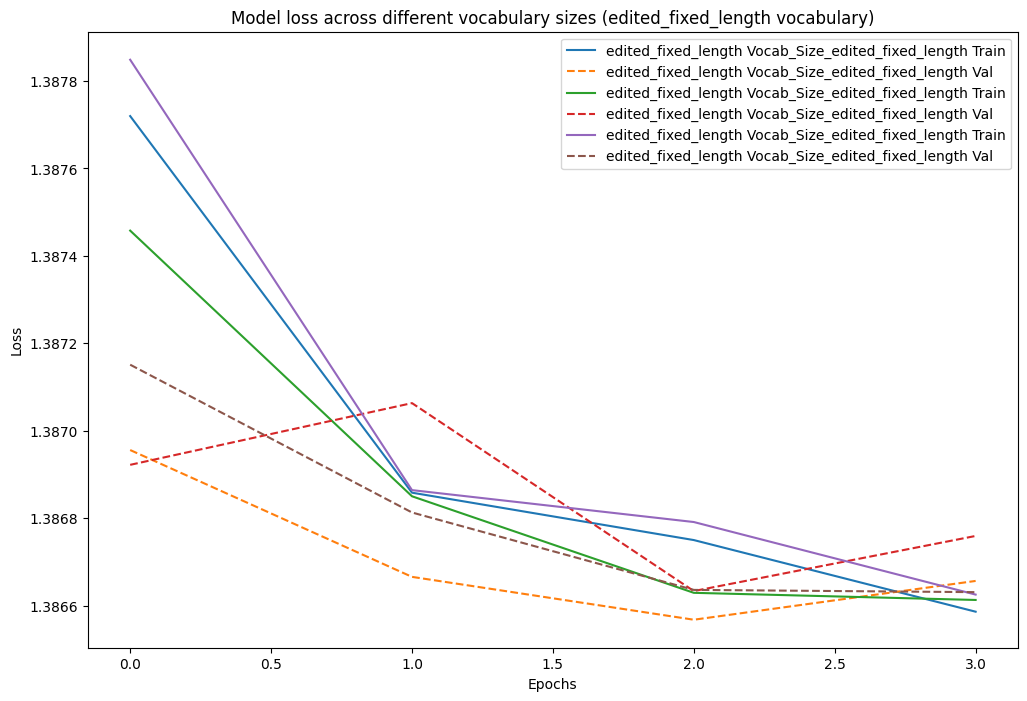

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Function to plot accuracy and loss for different vocabulary sizes and experiments (unidirectional)
def plot_unidirectional_results(results_df):
    # Iterate over each unique experiment name
    for experiment_name in results_df['model_name'].unique():
        # Filter the DataFrame for the current experiment
        experiment_df = results_df[results_df['model_name'] == experiment_name]

        # Plot accuracy
        plt.figure(figsize=(12, 8))
        for index, row in experiment_df.iterrows():
            history = row['history']
            vocab_size = row['model_name']

            # Debugging: Print the contents of the history object
            print(f"Model: {experiment_name}, Vocab Size: {vocab_size}, History Data: {history.history}")

            if 'accuracy' in history.history and 'val_accuracy' in history.history:
                plt.plot(history.history['accuracy'], label=f'{experiment_name} Vocab_Size_{vocab_size} Train')
                plt.plot(history.history['val_accuracy'], label=f'{experiment_name} Vocab_Size_{vocab_size} Val', linestyle='--')
            else:
                print(f"Missing keys in history for model: {experiment_name}, vocab size: {vocab_size}")

        plt.title(f"Model accuracy across different vocabulary sizes ({experiment_name} vocabulary)")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

        # Plot loss
        plt.figure(figsize=(12, 8))
        for index, row in experiment_df.iterrows():
            history = row['history']
            vocab_size = row['model_name']

            if 'loss' in history.history and 'val_loss' in history.history:
                plt.plot(history.history['loss'], label=f'{experiment_name} Vocab_Size_{vocab_size} Train')
                plt.plot(history.history['val_loss'], label=f'{experiment_name} Vocab_Size_{vocab_size} Val', linestyle='--')
            else:
                print(f"Missing keys in history for model: {experiment_name}, vocab size: {vocab_size}")

        plt.title(f"Model loss across different vocabulary sizes ({experiment_name} vocabulary)")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

# Call the function with the DataFrame containing the results
plot_unidirectional_results(df_unidirectional)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/458_M6_A3_lstm_uni.ipynb"

Mounted at /content/drive
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/458_M6_A3_lstm_uni.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 560, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/loc